In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G        574M         24G        1.2M        809M         24G
Swap:            0B          0B          0B


# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches
import pandas as pd

## Get Files

In [ ]:
url = 'https://drive.google.com/file/d/1EIpu9RMTN_juIlRx62a8RLIIZ1LykcB5/view?usp=sharing'
batch_name = '081221_final_fishhook_tests'

In [ ]:
!ls "{batch_name}.tar.xz" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

Downloading...
From: https://drive.google.com/uc?id=1EIpu9RMTN_juIlRx62a8RLIIZ1LykcB5
To: /content/081221_final_fishhook_tests.tar.xz
100% 3.39G/3.39G [00:48<00:00, 69.8MB/s]


In [ ]:
!ls "{batch_name}" 2>/dev/null 1>/dev/null || tar xvf "{batch_name}.tar.xz"

081221_final_fishhook_tests/
081221_final_fishhook_tests/stationary_2/
081221_final_fishhook_tests/stationary_2/pico.npts
081221_final_fishhook_tests/stationary_8/
081221_final_fishhook_tests/stationary_8/pico.npts
081221_final_fishhook_tests/stationary_3/
081221_final_fishhook_tests/stationary_3/pico.npts
081221_final_fishhook_tests/stationary_6/
081221_final_fishhook_tests/stationary_6/pico.npts
081221_final_fishhook_tests/triangle_1/
081221_final_fishhook_tests/triangle_1/imu.csv
081221_final_fishhook_tests/triangle_1/pico.npts
081221_final_fishhook_tests/triangle_1/times.log
081221_final_fishhook_tests/triangle_3/
081221_final_fishhook_tests/triangle_3/imu.csv
081221_final_fishhook_tests/triangle_3/pico.npts
081221_final_fishhook_tests/stationary_5/
081221_final_fishhook_tests/stationary_5/pico.npts
081221_final_fishhook_tests/stationary_7/
081221_final_fishhook_tests/stationary_7/pico.npts
081221_final_fishhook_tests/stationary_1/
081221_final_fishhook_tests/stationary_1/pico.npts

In [ ]:
cache_processed_data = True 

# Run List

In [ ]:
root = "081221_final_fishhook_tests/"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

pretest_1
pretest_2
stationary_1
stationary_2
stationary_3
stationary_4
stationary_5
stationary_6
stationary_7
stationary_8
triangle_1
triangle_2
triangle_3


In [ ]:
runs = [a.strip() for a in open(run_list) if a != '']

In [ ]:
fs = 1e6
dt = 1.0 / fs

![image.png](attachment:image.png)


In [ ]:
import numpy as np

In [ ]:
L = 9.025
W = 2.96
D = -3.5

h_locs = np.array((
    (607, 296,  -55),
    (620,   0, -155),
    (  0, 148, -100),
    (291,   0, -255),
    (280, 296, -200),
)).astype(np.float64)
h_locs /= 100

ground_truth = np.array((
    (461.52, 260.53),
    (  0.00, 148.00),
    (458.52,  38.55),
)).astype(np.float64)
ground_truth /= 100
ground_truth = np.vstack((ground_truth, ground_truth[0:1, ...]))

# Helpers

## Pico Loader

In [ ]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3, apply_abs=True):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n
        self.apply_abs = apply_abs

    def __call__(self, data):
        if self.apply_abs:
            if len(data.shape) == 1:
                return np.convolve(np.abs(data), self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
            return out
        else:
            if len(data.shape) == 1:
                return np.convolve(data, self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
            return out
            

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

    
import struct
class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None,  # {'fs': fs,},
                 preserve_chA=False,
                 num_channels=6
                ):  
        self.filename = filename
        self.file = None
        self.preserve_chA = preserve_chA
        self.num_channels = num_channels

        self.transformers = []
        if bp_args is not None:
            self.transformers.append(BP(**bp_args))
        if ma_args is not None:
            self.transformers.append(MA(**ma_args))
        if hil_args is not None:
            self.transformers.append(Hilbert(**hil_args))
    
    def open(self):
        if self.file is not None:
            self.close()
        
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)[:, :self.num_channels]
            dtype = arr.dtype
            
            if self.preserve_chA:
                chA = arr[:, 0].copy()
            
            for tran in self.transformers:
                arr = tran(arr)
            
            arr = arr.astype(dtype)
            if self.preserve_chA:
                arr[:, 0] = chA
            
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    
    def __exit__(self, ex_type, value, traceback):
        self.close()

In [ ]:
import numpy as np
import subprocess
from tqdm.notebook import trange
import functools

@functools.lru_cache(maxsize=None)
def load_pico_file(filename, num_channels=6):
    with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
        t0 = reader.get()[0]
    
    # WARNING: THIS IS A HACK! Note the magic numbers
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)
    chunk_size = PicoDataLoader.bufsize
    y = np.empty((chunk_size * num_chunks, num_channels))
    index = 0
    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, preserve_chA=True,
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args=None,  #{'fs': fs, 'dt': 6e-5},
                 hil_args={'fs': fs,},
                 num_channels=num_channels,
                       ) as reader:
        try:
            for i in trange(num_chunks):
                t, y[index:index + chunk_size, ...] = reader.get()
                index += chunk_size
                t_curr += dt * chunk_size
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
    t = np.arange(y.shape[0]) * dt

    t.flags.writeable = False
    y.flags.writeable = False

    return t, y

In [ ]:
# import numpy as np
# import subprocess
# from tqdm.notebook import trange

# def load_run(filename, num_channels=6):
#     with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
#         t0 = reader.get()[0]

#     num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)

#     arrs = []
#     t_curr = t0
#     with PicoDataLoader(filename, preserve_chA=True,
#                  bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
#                  ma_args=None,  #{'fs': fs, 'dt': 6e-5},
#                  hil_args={'fs': fs,},
#                  num_channels=num_channels,
#                        ) as reader:
#         try:
#             for i in trange(num_chunks):
#                 t, arr = reader.get()
#                 arrs.append(arr)
#                 # print(t - t0, t_curr - t0, t - t_curr)
#                 t_curr += dt * arr.shape[0]
#         except StopIteration:
#             print(f"Got {len(arrs)} chunks of {num_chunks} expected")
    
#     import time
#     t_start = time.time()
#     y = np.vstack(arrs)
#     t = np.arange(y.shape[0]) * dt
#     del arrs
#     print(time.time() - t_start)
#     # t.flags.writeable = False
#     # y.flags.writeable = False

#     return t, y

## Ping Indices

In [ ]:
def get_ping_indices(ping_ch, fs=fs, pinger_zc_thresh=-1000, min_down_length=0.350):
    ping_ch = ping_ch.copy()
    ping_ch[0] = 0
    ping_ch[-1] = 0


    on = ping_ch < pinger_zc_thresh
    diff = np.diff(on.astype('int'))
    down = np.where(diff > 0)[0]
    up = np.where(diff < 0)[0]

    correct_mask = (up - down) > fs * min_down_length
    # 0.350 ~= 0.8 * (t_between_ping / 2)

    down = down[correct_mask]
    # down += 1  # For the diff
    
    del ping_ch  # Do we really need to?
    return down

## Zero Crossing

In [ ]:
def get_simple_zc(ch, zero_crossing_thresh=250):
    # For boolean arrays it short circuits and returns the index of the first `True`. If no `True`, it returns `0` 
    return np.argmax(ch > zero_crossing_thresh, axis=0) 

## Ranges

In [ ]:
def get_ranges(hydro, ping_index, fs=fs, max_dist=10, ping_size=5e-3, v_sound=1480):
    ping_len = max_dist / v_sound + ping_size
    win = slice(ping_index, ping_index + int(fs * ping_len))
    ranges = np.zeros((hydro.shape[1],))
    for i, row in enumerate(hydro[win, :].T):
        zero_in = get_simple_zc(row)  # Est_ZC_stage_1(row)
        if zero_in <= 0: 
            zero_in = np.nan
        ranges[i] = zero_in * v_sound / fs
        if ranges[i] < 0:
            print(zero_in,v_sound, fs)
            raise Exception()
        if ranges[i] > max_dist:
            ranges[i] = np.nan
    return ranges

## Draw Pool

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches  # For circles and rectangles

In [ ]:
def draw_pool(ax, set_lim=True):
    ax.set_aspect('equal', 'box')
    if set_lim:
        ax.set_xlim(0, L)
        ax.set_ylim(0, W)
    ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
    ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

    ax.plot(*ground_truth.T, color='green')

# Load Run

In [ ]:
run = runs[3]  #runs[8]
run

'stationary_2'

In [ ]:
pico_file = f"{root}/{run}/pico.npts"
!du -h {pico_file}

592M	081221_final_fishhook_tests//stationary_2/pico.npts


In [ ]:
t, y = load_pico_file(pico_file)

  0%|          | 0/517 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
t[-1], y.shape

# Get Ranges

In [ ]:
indices = get_ping_indices(y[:, 0])

In [ ]:
ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]

In [ ]:

# ranges = 0.01578795189472405 + 0.7183563433803977 * np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = 0.5915894806437689+0.6304301582955311* np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]

In [ ]:
print(f"Found {ranges.shape[0]} pings of {indices.shape[0]}")
print(f"Mean:\t{np.nanmean(ranges, axis=0)}\nStd:\t{np.nanstd(ranges, axis=0)}")

Found 38 pings of 50
Mean:	[2.55278338 2.73209829 3.64033579 3.6164697  3.63571971]
Std:	[0.35796493 0.46763771 0.47256715 0.4732167  0.47365274]


In [ ]:
get_ranges(y[:, 1:], indices[1]) * fs / 1480

array([2217., 2240., 3229., 3176., 3211.])

In [ ]:
(np.array((1.51,3.23,4.77,3.72,2.30)) * fs / 1480).astype(int)

array([1020, 2182, 3222, 2513, 1554])

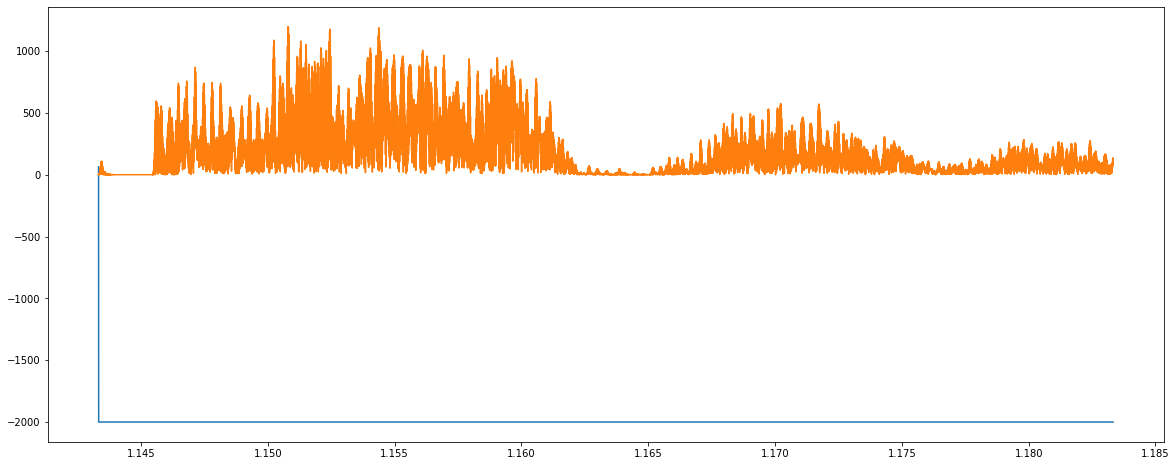

In [ ]:
plt.subplots(1,1, figsize=(20,8))
win = slice(indices[1], indices[1] + int(fs * 40e-3))
plt.plot(t[win], y[win, 0])
plt.plot(t[win], y[win, 1])

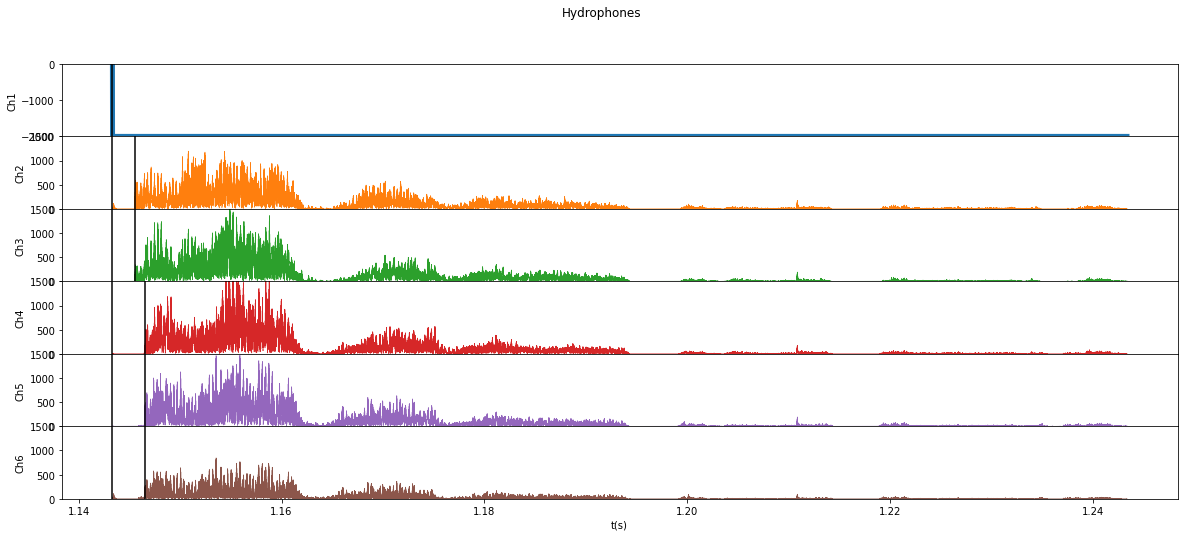

In [ ]:
f, axs = plt.subplots(y.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(indices[1], indices[1] + int(fs * 100e-3))
for (i, ax), row, color in zip(enumerate(axs), y.T, colors):
    if i != 0:
        ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.5)
        ax.set_ylim(0,1500)
        ind = get_simple_zc(row[loc])
        ax.axvline(t[loc][ind], color='black')
    else:
        ax.plot(t[loc], (row[loc]), label=f"Ch{i+1}", color=color, linewidth=5)
        ax.set_ylim(-2000,0)

    ax.set_ylabel(f"Ch{i+1}")
    ax.set_xlim(*ax.get_xlim())


for ax in axs:
    for ts in get_ping_indices(y[:, 0]) * dt:
        ax.axvline(ts, color='black')

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

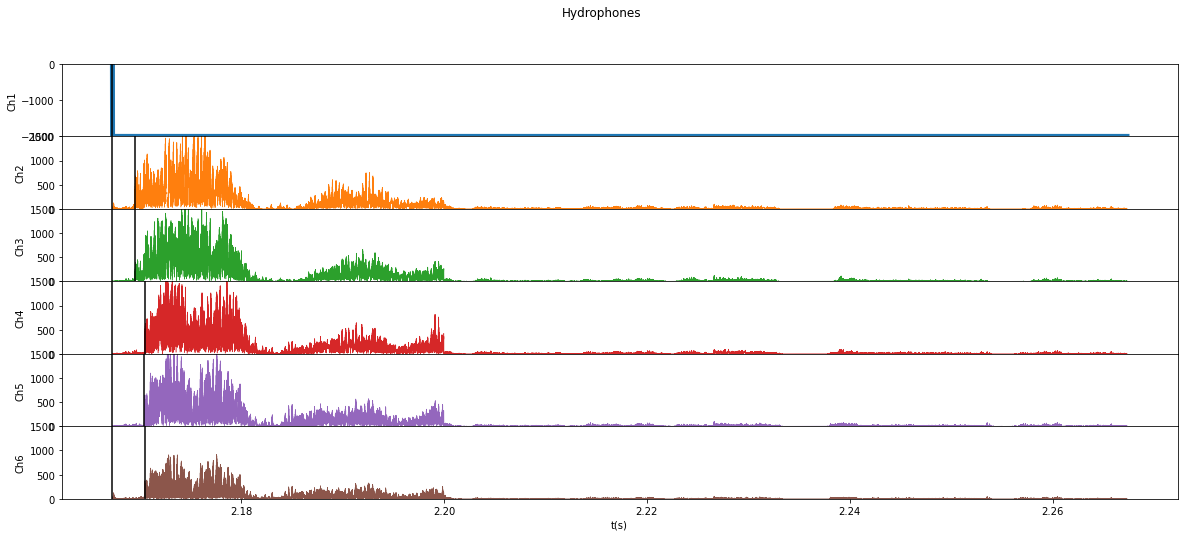

In [ ]:
f, axs = plt.subplots(y.shape[1], 1, figsize=(20,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(indices[2], indices[2] + int(fs * 100e-3))
for (i, ax), row, color in zip(enumerate(axs), y.T, colors):
    if i != 0:
        ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.5)
        ax.set_ylim(0,1500)
        ind = get_simple_zc(row[loc])
        ax.axvline(t[loc][ind], color='black')
    else:
        ax.plot(t[loc], (row[loc]), label=f"Ch{i+1}", color=color, linewidth=5)
        ax.set_ylim(-2000,0)

    ax.set_ylabel(f"Ch{i+1}")
    ax.set_xlim(*ax.get_xlim())


for ax in axs:
    for ts in get_ping_indices(y[:, 0]) * dt:
        ax.axvline(ts, color='black')

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

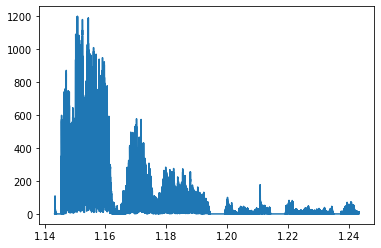

Text(0, 0.5, 'Channel')

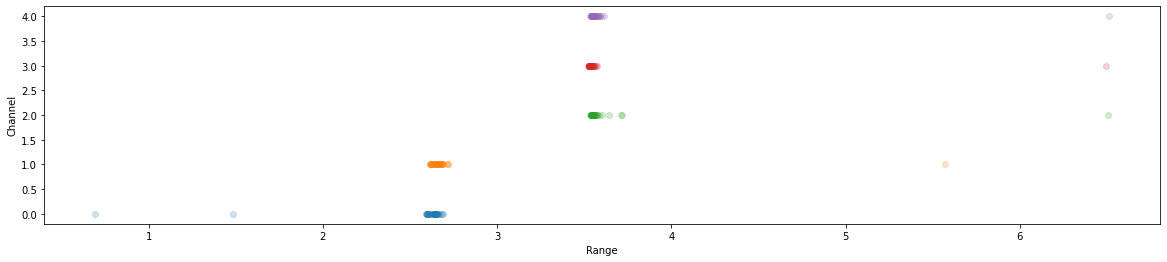

In [ ]:
plt.figure(figsize=(20,4))
for i in range(ranges.shape[1]):
    plt.plot(ranges[:, i], np.zeros_like(ranges[:, i]) + i, 'o', alpha=0.2)
plt.xlabel('Range')
plt.ylabel('Channel')

# Positions

## Direct Calc

In [ ]:
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, ranges)):
    locs[i] = minimize(error, xx0, args=(h_locs[:, :], ran), method='Nelder-Mead').x


Text(0.5, 0.98, 'Stationary')

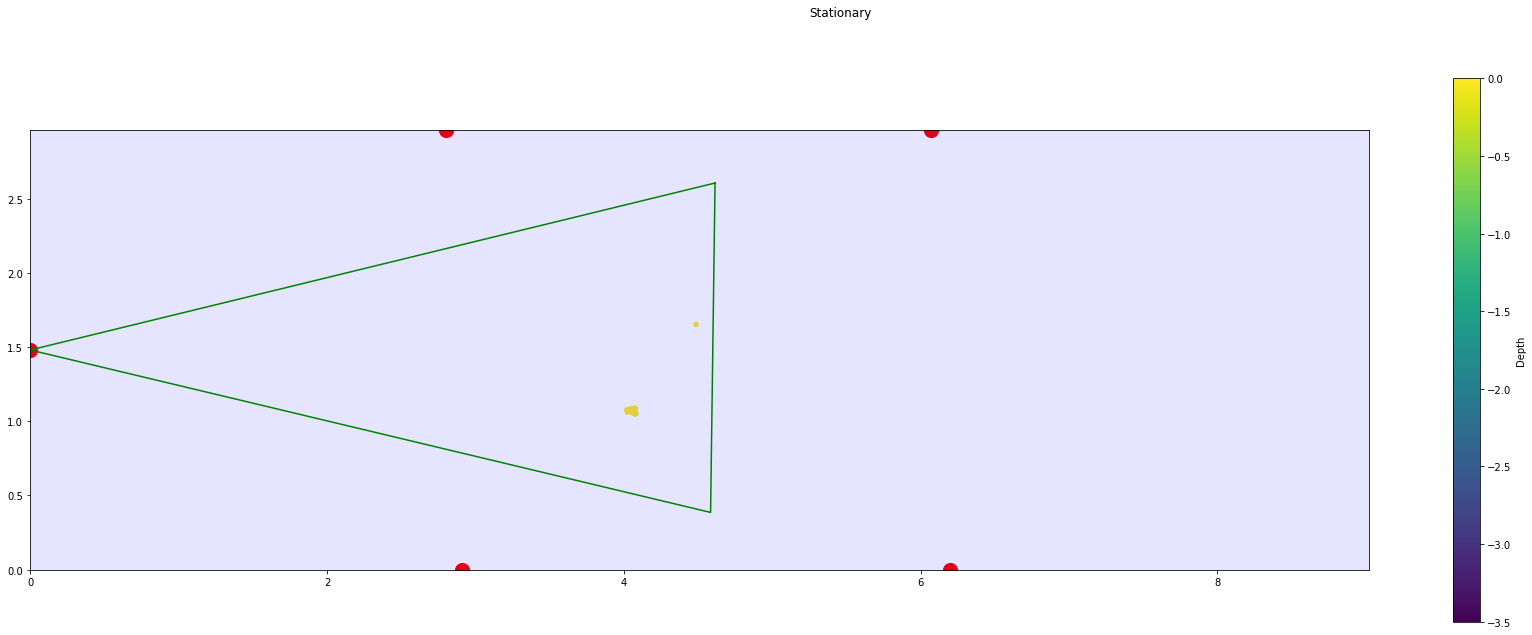

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
# plt.scatter(x0[:, 0], x0[:, 1], c=x0[:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")

# cs = [
#       ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
#       for loc in h_locs
# ]

Text(0.5, 0.98, 'Stationary')

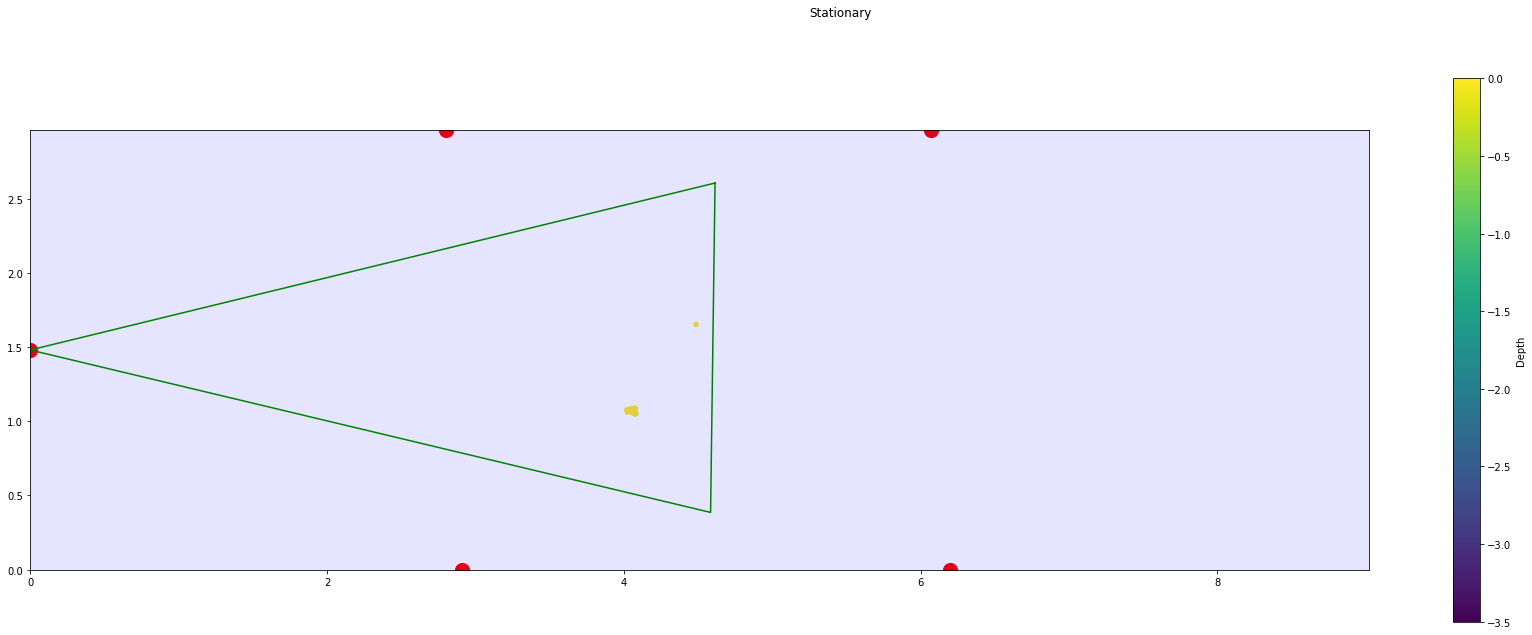

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
# plt.scatter(x0[:, 0], x0[:, 1], c=x0[:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")

# cs = [
#       ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
#       for loc in h_locs
# ]

# Full

In [ ]:
import numpy as np
from scipy.optimize import minimize
def get_ranges_from_file(run_number):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    return indices * dt, ranges

In [ ]:
import numpy as np
from scipy.optimize import minimize
def get_simple_locs_from_file(run_number):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = 0.01578795189472405 + 0.7183563433803977 * np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
    
    l_h_locs = h_locs[:, :]
    l_ranges = ranges[:, :]

    x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
        locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [ ]:
import numpy as np
from scipy.optimize import minimize

def get_simple_locs_fix_depth(run_number, depth=-0.5):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]
    
    dists_2d = np.sqrt(ranges**2 - (h_locs[:, 2] - depth)**2)

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

    x0 = (h_locs[None, :, :2] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    locs[:, 2] = depth
    for i, (xx0, ran) in enumerate(zip(x0, dists_2d)):
        locs[i, :2] = minimize(error, xx0, args=(h_locs[:, :2], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [ ]:
import numpy as np
from scipy.optimize import minimize
def get_simple_locs_with_remap(run_number, remap=[0,1,2,3,4]):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges =  np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    ranges = ranges[:, remap]
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
    
    l_h_locs = h_locs[:, :]
    l_ranges = ranges[:, :]

    x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
        locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

In [ ]:
import numpy as np
from scipy.optimize import minimize

def get_simple_locs_fix_depth(run_number, remap=[0,1,2,3,4], depth=-0.5):
    run = runs[run_number]
    pico_file = f"{root}/{run}/pico.npts"
    _, y = load_pico_file(pico_file)
    
    indices = get_ping_indices(y[:, 0])
    ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
    valid_ranges = ~np.isnan(ranges).any(axis=1)
    indices, ranges = indices[valid_ranges], ranges[valid_ranges]
    
    
    dists_2d = np.sqrt(ranges**2 - (h_locs[:, 2] - depth)**2)

    def error(x, c, r):
        return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

    x0 = (h_locs[None, :, :2] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)

    locs = np.empty((ranges.shape[0], h_locs.shape[1]))
    locs[:, 2] = depth
    for i, (xx0, ran) in enumerate(zip(x0, dists_2d)):
        locs[i, :2] = minimize(error, xx0, args=(h_locs[:, :2], ran), method='Nelder-Mead').x
    
    return indices * dt, locs

# Somethign

In [ ]:
ts, locs = get_simple_locs_fix_depth(2)

  0%|          | 0/515 [00:00<?, ?it/s]

NameError: ignored

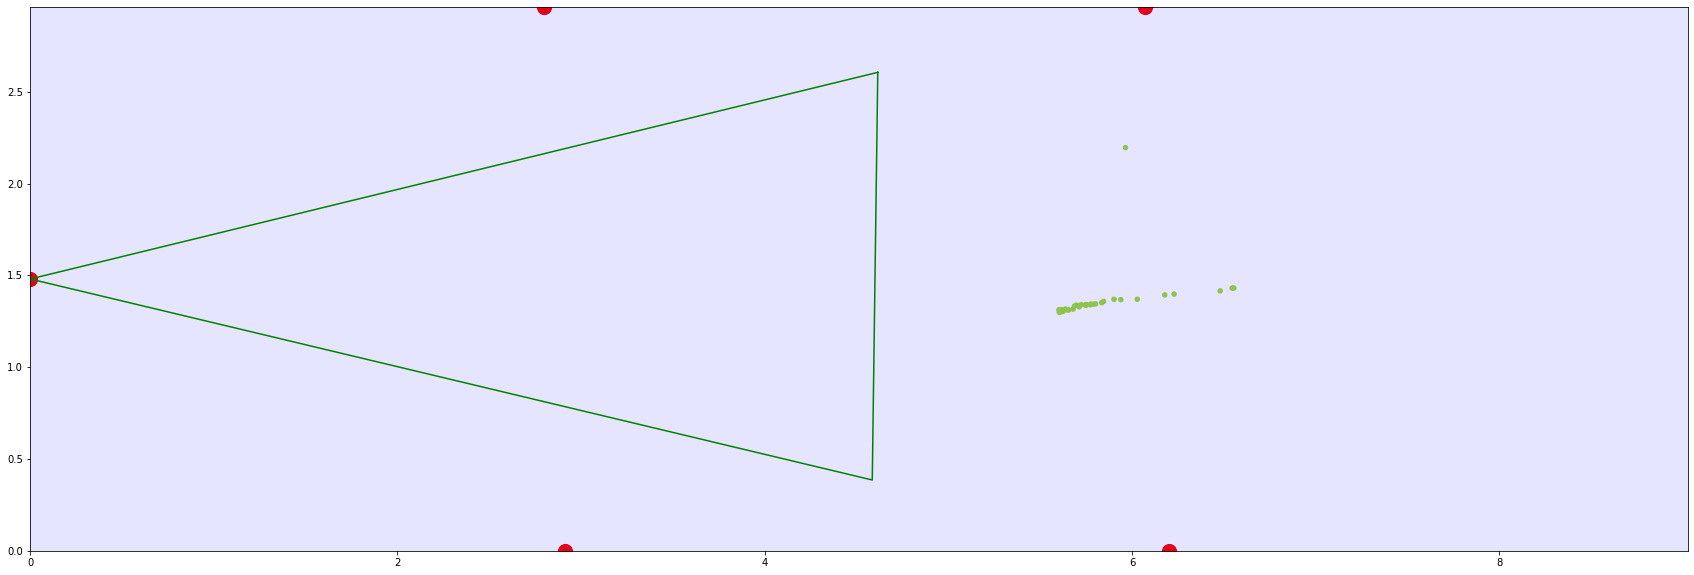

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0)
plt.scatter(all_locs[0][:, 0], all_locs[0][:, 1], c=all_locs[0][:, 2], s=20, vmin=D, vmax=0)

plt.colorbar(label='Depth')

f.suptitle("Stationary")


# Plots

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Channel')

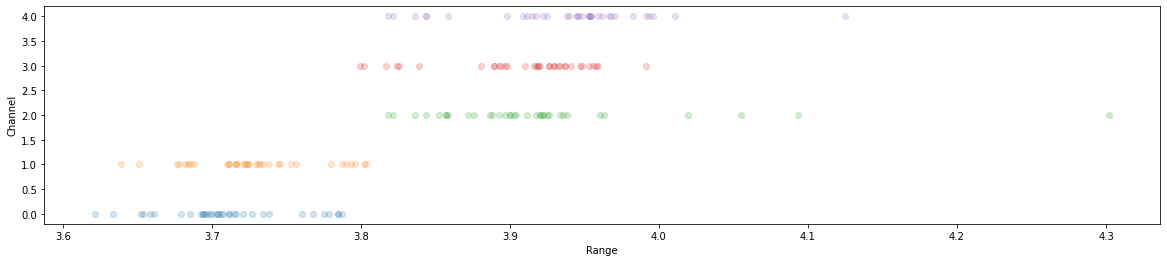

In [ ]:
plt.figure(figsize=(20,4))
for i in range(ranges.shape[1]):
    plt.plot(ranges[:, i], np.zeros_like(ranges[:, i]) + i, 'o', alpha=0.2)
plt.xlabel('Range')
plt.ylabel('Channel')

In [ ]:
# Get all locs:
all_ts = []
all_locs = []
for i in trange(2, 2 + 8):
    ts, locs = get_simple_locs_from_file(i)
    all_ts.append(ts)
    all_locs.append(locs)

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Stationary')

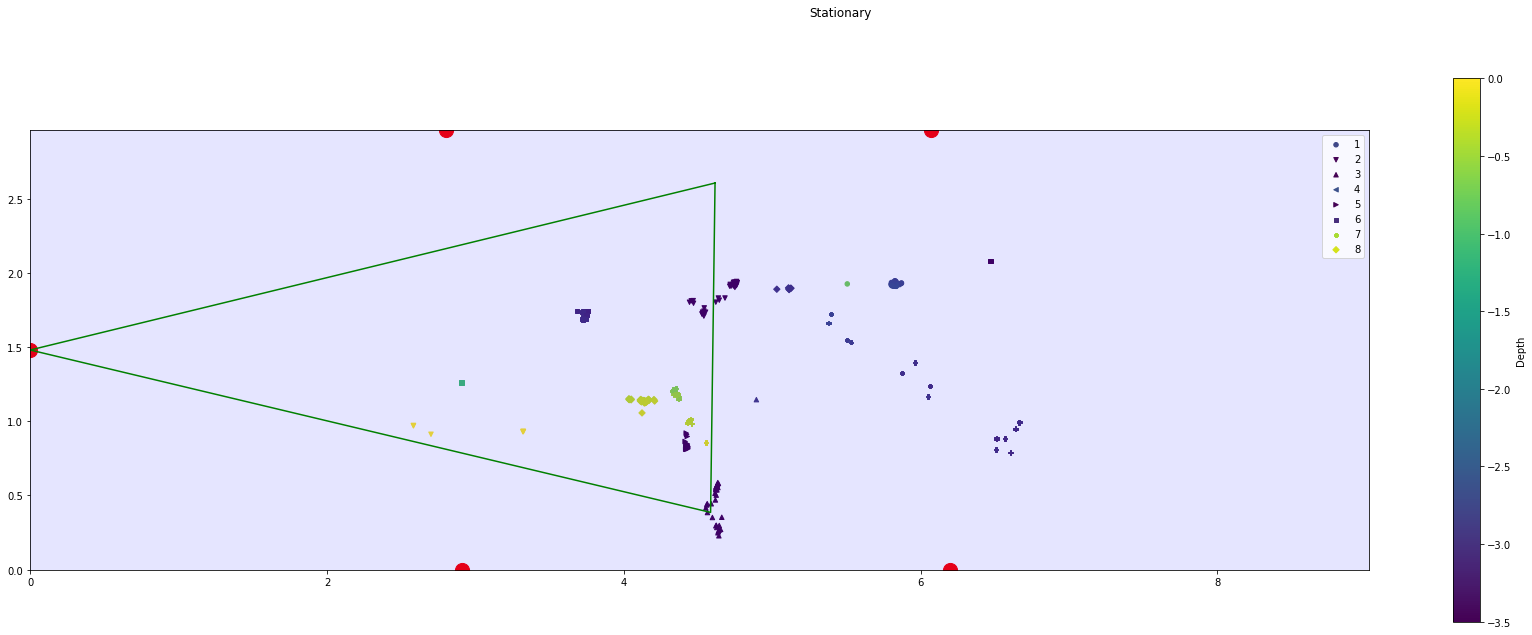

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax)
symbols = list("ov^<>sPD")
for i, (locs, sym) in enumerate(zip(all_locs, symbols), 1):
    plt.scatter(locs[:, 0], locs[:, 1], marker=sym, c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i}")

plt.colorbar(label='Depth')

plt.legend()
f.suptitle("Stationary")


Text(0.5, 0.98, 'Stationary')

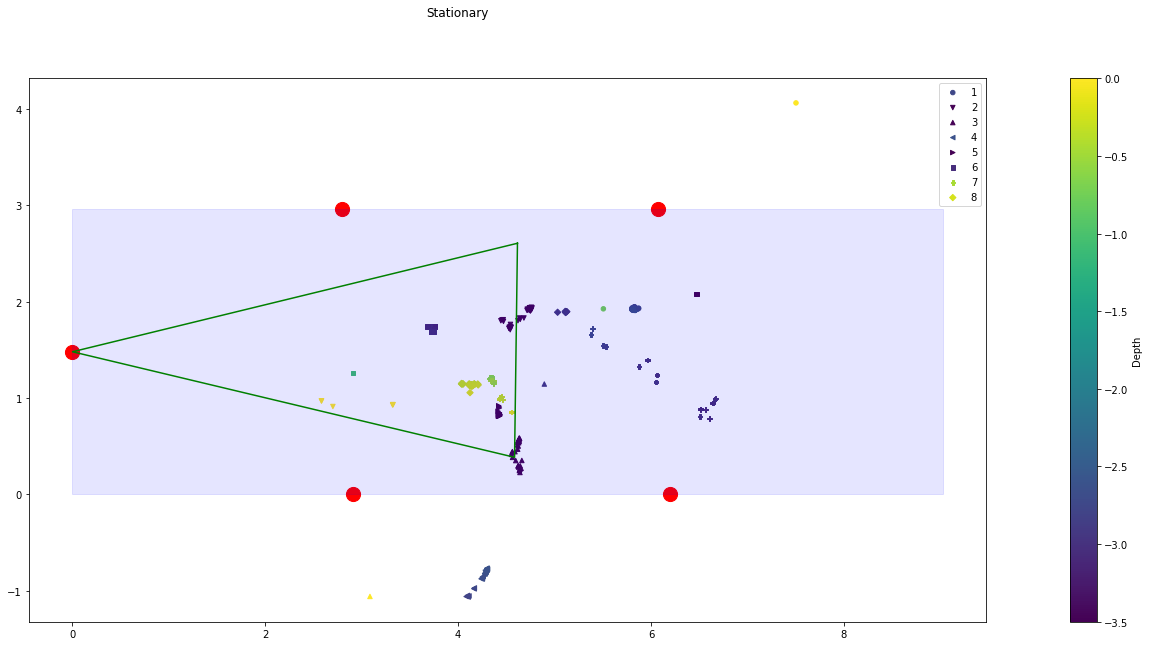

In [ ]:
f, ax = plt.subplots(1,1, figsize=(30,10))

draw_pool(ax, set_lim=False)
symbols = list("ov^<>sPD")
for i, (locs, sym) in enumerate(zip(all_locs, symbols), 1):
    plt.scatter(locs[:, 0], locs[:, 1], marker=sym, c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i}")

plt.colorbar(label='Depth')

plt.legend()
f.suptitle("Stationary")


# Try to get a linear fit

In [ ]:
# Get all ranges:
all_ranges = []
for i in trange(2, 2 + 8):
    _, ran = get_ranges_from_file(i)
    all_ranges.append(ran)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

  0%|          | 0/539 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

In [ ]:
all_ranges_mean = np.vstack(tuple(np.nanmean(r, axis=0) for r in all_ranges))
all_ranges_mean

array([[3.11088211, 3.39531474, 4.83597789, 4.79812105, 4.82865579],
       [5.179112  , 4.70791289, 3.96893244, 3.94735733, 3.96955733],
       [6.52819778, 3.20510444, 3.18615222, 3.20535111, 4.28871111],
       [8.09196727, 2.10701545, 2.08939   , 2.10768818, 4.87717182],
       [6.50632667, 3.18956444, 3.16802222, 3.19009889, 3.54612111],
       [4.94706244, 4.8454478 , 2.77954829, 2.75359415, 2.80355317],
       [3.39040737, 3.35597789, 3.38701895, 3.79086421, 5.25158526],
       [3.71019086, 3.72858514, 3.92085829, 3.90732686, 3.93641943]])

In [ ]:
actual_all_ranges = np.array((
    (1.51,3.23,4.77,3.72,2.30),
    (3.33,4.14,2.96,2.98,1.70),
    (4.79,5.22,1.54,3.12,2.33),
    (6.24,6.46,0.50,3.86,3.50),
    (4.99,5.02,1.55,2.78,2.73),
    (3.86,3.57,3.00,2.20,2.64),
    (2.97,1.96,4.74,2.68,3.48),
    (2.08,2.41,4.64,3.05,2.78)
))

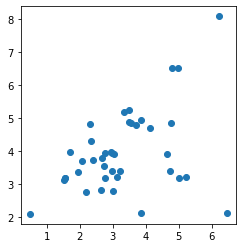

In [ ]:
plt.gca().set_aspect('equal', 'box')
plt.scatter(actual_all_ranges, all_ranges_mean)

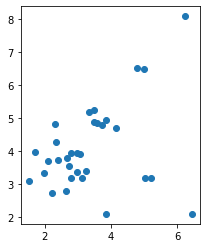

In [ ]:
plt.scatter(actual_all_ranges[:, [0,1,3,4]], all_ranges_mean[:, [0,1,3,4]])
plt.gca().set_aspect('equal', 'box')

In [ ]:
from numpy.polynomial import Polynomial as Poly

In [ ]:
Poly.fit(all_ranges_mean[:, [0,1,3,4]].ravel(), actual_all_ranges[:, [0,1,3,4]].ravel(), 1, domain=[])#(0,10))

Polynomial([1.9754456, 0.3385314], domain=[-1.,  1.], window=[-1.,  1.])

In [ ]:
Poly.fit?

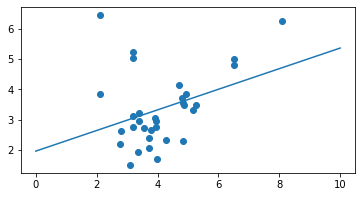

In [ ]:
plt.scatter(all_ranges_mean[:, [0,1,3,4]], actual_all_ranges[:, [0,1,3,4]])
x = np.linspace(0,10,100)
y = 1.9754455977760899 + 0.33853139500853524 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

In [ ]:
mask = ~((actual_all_ranges[:, [0,1,3,4]] / all_ranges_mean[:, [0,1,3,4]] ) > 1)

In [ ]:
Poly.fit(all_ranges_mean[:, [0,2,3,4]][mask].ravel(), actual_all_ranges[:, [0,2,3,4]][mask].ravel(), 1, domain=[])#(0,10))

Polynomial([0.59158948, 0.63043016], domain=[-1.,  1.], window=[-1.,  1.])

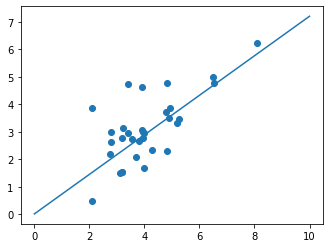

In [ ]:
plt.scatter(all_ranges_mean[:, [0,2,3,4]], actual_all_ranges[:, [0,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

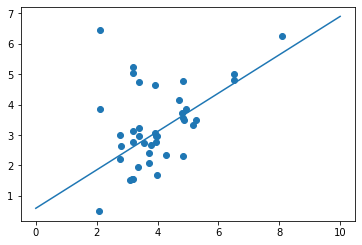

In [ ]:
plt.scatter(all_ranges_mean[:, [0,1,2,3,4]], actual_all_ranges[:, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.5915894806437689+0.6304301582955311*x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

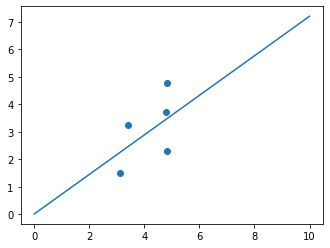

In [ ]:
plt.scatter(all_ranges_mean[0, [0,1,2, 3,4]], actual_all_ranges[0, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

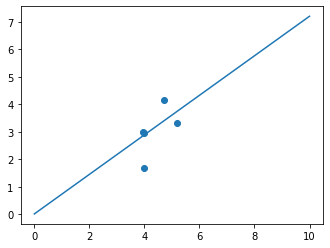

In [ ]:
plt.scatter(all_ranges_mean[1, [0,1,2, 3,4]], actual_all_ranges[1, [0,1,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

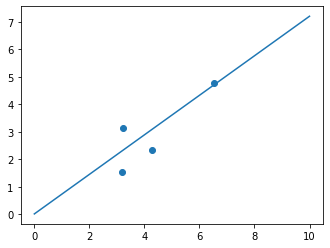

In [ ]:
plt.scatter(all_ranges_mean[2, [0,2, 3,4]], actual_all_ranges[2, [0,2,3,4]])
x = np.linspace(0,10,100)
y = 0.01578795189472405 + 0.7183563433803977 * x
plt.plot(x,y)
plt.gca().set_aspect('equal', 'box')

# Randomly swap channels around

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

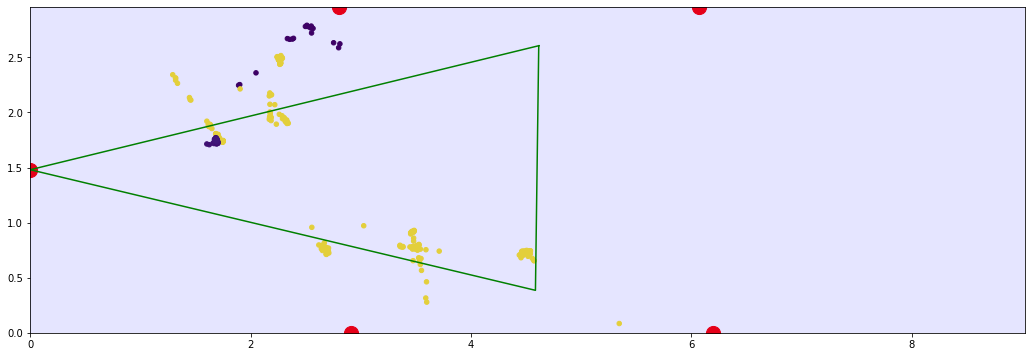

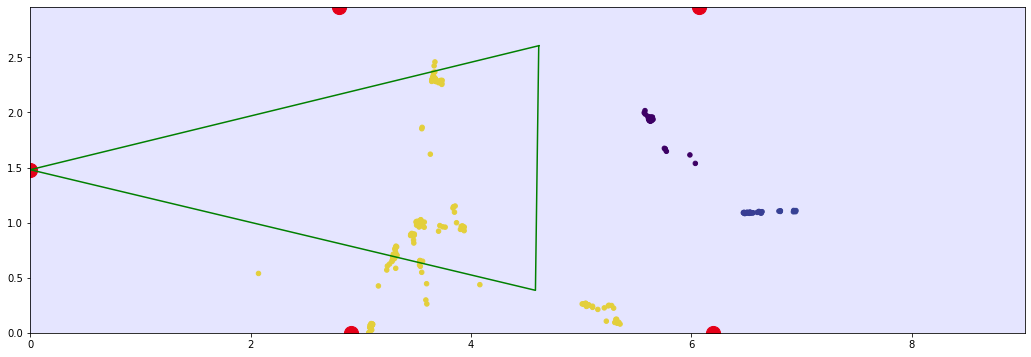

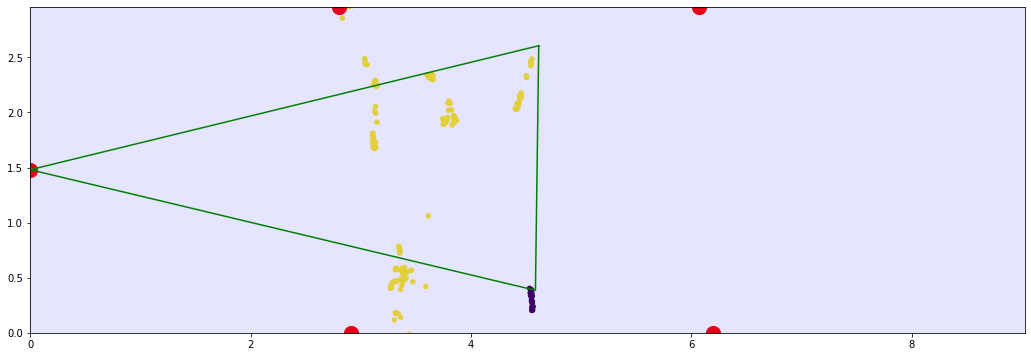

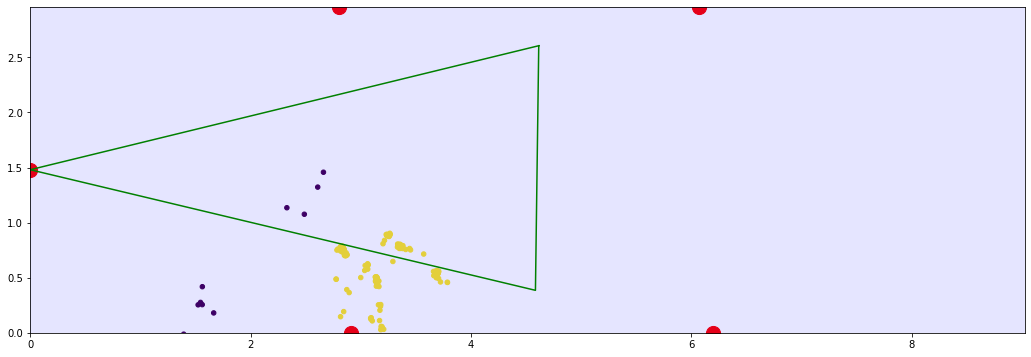

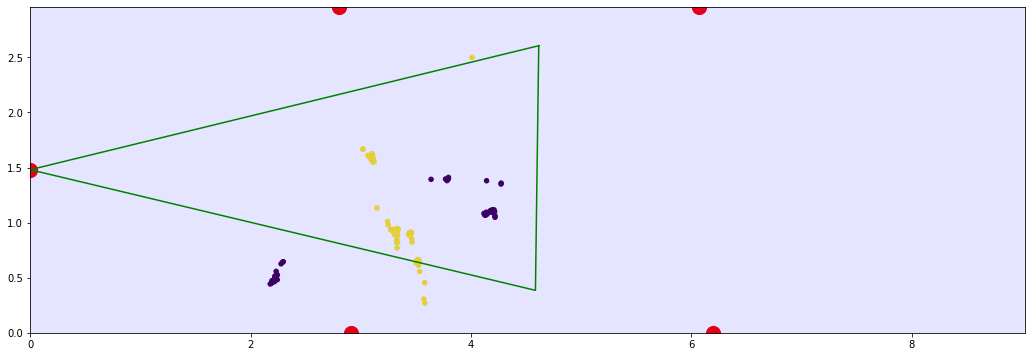

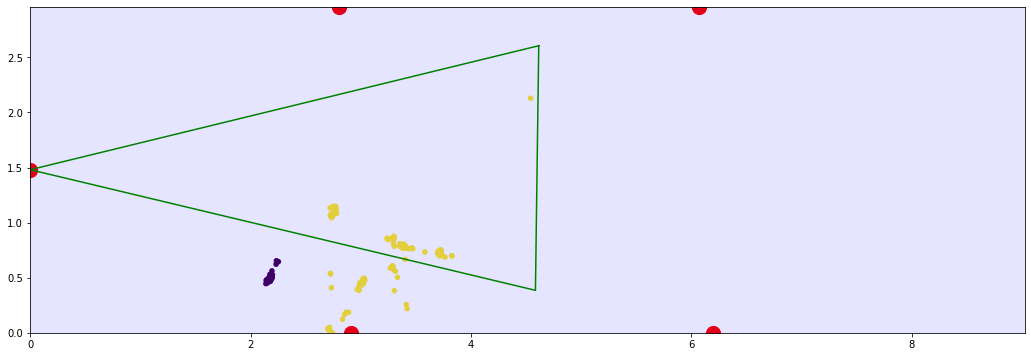

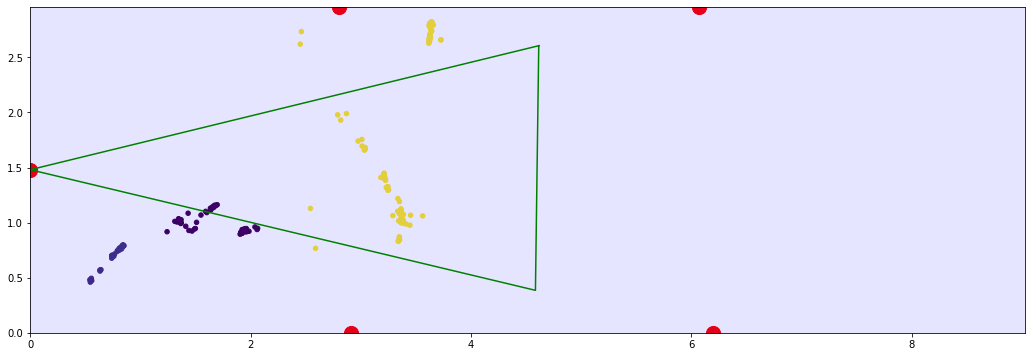

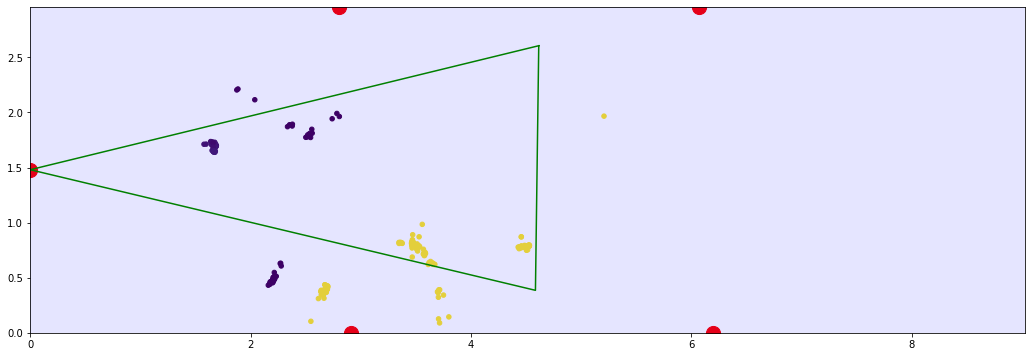

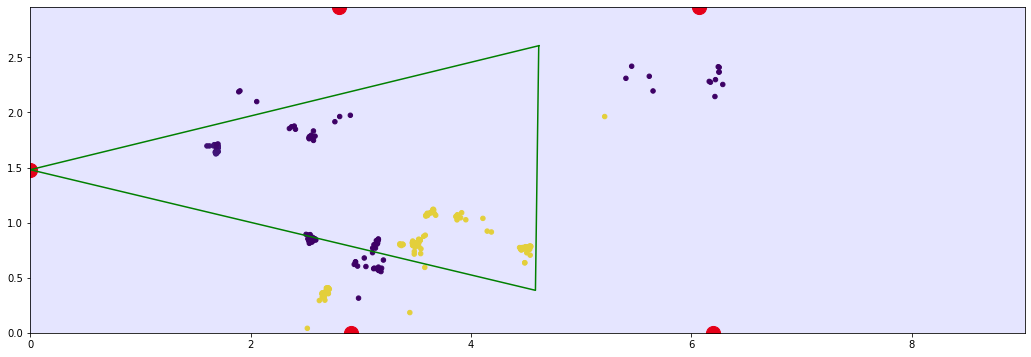

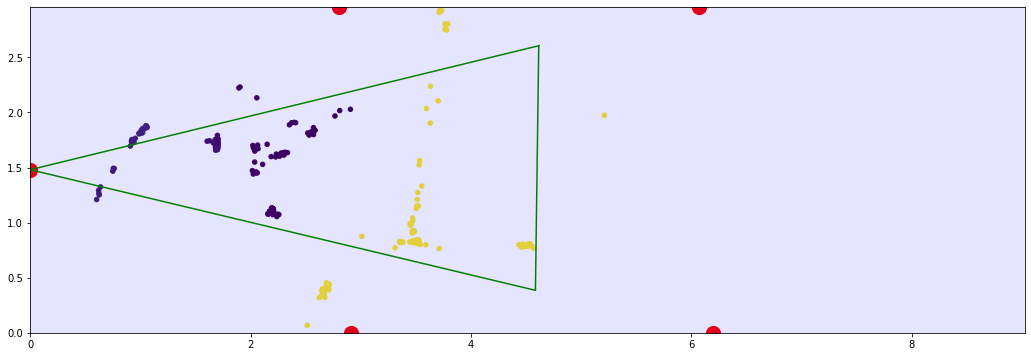

In [ ]:
import itertools
for k,l in itertools.combinations(range(5),2):
    ind = list(range(5))
    ind[k] = l
    ind[l] = k
    plt.figure(figsize=(18,6))
    draw_pool(plt.gca())
    for i in trange(2, 2 + 8):
        _, locs = get_simple_locs_with_remap(i, ind)
        plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i-1}")

In [ ]:
for k,l in itertools.combinations(range(5),2):
    ind = list(range(5))
    ind[k] = l
    ind[l] = k
    print(ind)

[1, 0, 2, 3, 4]
[2, 1, 0, 3, 4]
[3, 1, 2, 0, 4]
[4, 1, 2, 3, 0]
[0, 2, 1, 3, 4]
[0, 3, 2, 1, 4]
[0, 4, 2, 3, 1]
[0, 1, 3, 2, 4]
[0, 1, 4, 3, 2]
[0, 1, 2, 4, 3]


  0%|          | 0/8 [00:00<?, ?it/s]

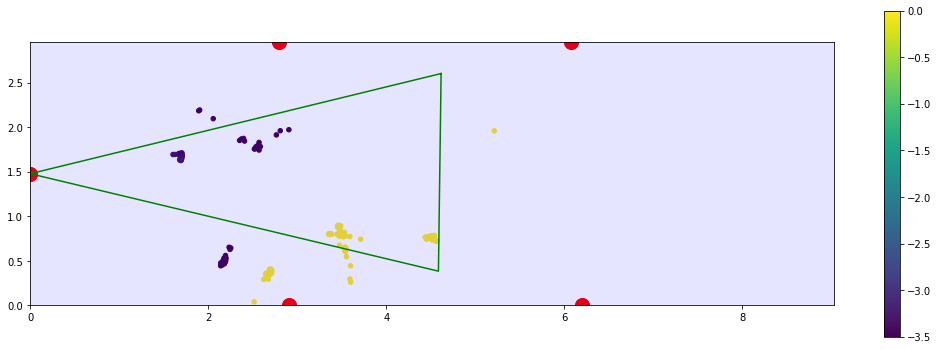

In [ ]:

plt.figure(figsize=(18,6))
draw_pool(plt.gca())
for i in trange(2, 2 + 8):
    _, locs = get_simple_locs_with_remap(i, [0,1,2,3,4])
    plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=D, vmax=0, label=f"{i-1}")
plt.colorbar()

# Check with Ground Truth

In [ ]:
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

l_h_locs = h_locs[:, :]
l_ranges = np.array((
    (1.51,3.23,4.77,3.72,2.30),
    (3.33,4.14,2.96,2.98,1.70),
    (4.79,5.22,1.54,3.12,2.33),
    (6.24,6.46,0.50,3.86,3.50),
    (4.99,5.02,1.55,2.78,2.73),
    (3.86,3.57,3.00,2.20,2.64),
    (2.97,1.96,4.74,2.68,3.48),
    (2.08,2.41,4.64,3.05,2.78)
))

x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

locs = np.empty((l_ranges.shape[0], l_h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
    locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    print(xx0, ran, locs[i])


[ 4.21147564  1.887172   -1.38391465] [1.51 3.23 4.77 3.72 2.3 ] [ 4.6024251   2.65379759 -0.59387519]
[ 3.29581918  1.73556034 -1.6133024 ] [3.33 4.14 2.96 2.98 1.7 ] [ 2.83498025  2.1644276  -0.49917628]
[ 2.55051941  1.58352763 -1.52095386] [4.79 5.22 1.54 3.12 2.33] [ 1.41853338  1.82296686 -0.50647093]
[ 1.2190887   1.49661451 -1.24487153] [6.24 6.46 0.5  3.86 3.5 ] [ 0.00269231  1.49224361 -0.49851389]
[ 2.55475083  1.48650726 -1.53266744] [4.99 5.02 1.55 2.78 2.73] [ 1.42540068  1.14128278 -0.49627991]
[ 3.33709294  1.39601391 -1.65704325] [3.86 3.57 3.   2.2  2.64] [ 2.87846914  0.79028341 -0.49826351]
[ 4.13035225  1.25668489 -1.57892899] [2.97 1.96 4.74 2.68 3.48] [ 4.58901472  0.38436229 -0.49770152]
[ 4.14284741  1.56036377 -1.48909049] [2.08 2.41 4.64 3.05 2.78] [ 4.61251984  1.47850837 -0.49832813]


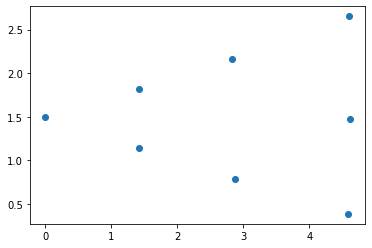

In [ ]:
plt.scatter(locs[:, 0], locs[:, 1])

In [ ]:
# Get all ranges:
all_ranges = []
for i in trange(2, 2 + 8):
    _, ran = get_ranges_from_file(i)
    all_ranges.append(ran)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
mean_ranges = np.vstack(tuple(np.nanmean(r, axis=0) for r in all_ranges))

In [ ]:
l_ranges

array([[1.51, 3.23, 4.77, 3.72, 2.3 ],
       [3.33, 4.14, 2.96, 2.98, 1.7 ],
       [4.79, 5.22, 1.54, 3.12, 2.33],
       [6.24, 6.46, 0.5 , 3.86, 3.5 ],
       [4.99, 5.02, 1.55, 2.78, 2.73],
       [3.86, 3.57, 3.  , 2.2 , 2.64],
       [2.97, 1.96, 4.74, 2.68, 3.48],
       [2.08, 2.41, 4.64, 3.05, 2.78]])

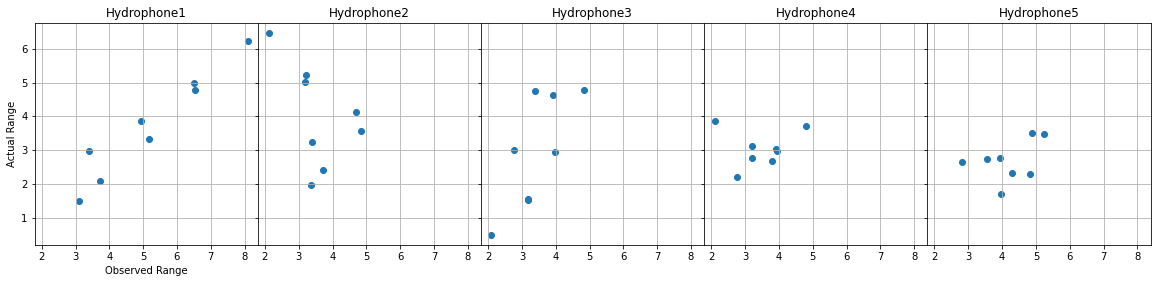

In [ ]:
f, axs = plt.subplots(1,5,sharex=True, sharey=True, figsize=(20,6))
for ax, mr, lr, i in zip(axs, mean_ranges.T, l_ranges.T, range(5)):
    ax.set_aspect('equal', 'box')
    ax.scatter(mr, lr)
    ax.grid()
    ax.set_title(f"Hydrophone {i+1}")

axs[0].set_xlabel("Observed Range")
axs[0].set_ylabel("Actual Range")
plt.subplots_adjust(wspace=0.0, hspace=0.0)

***NO RELATIONSHIP UGH***

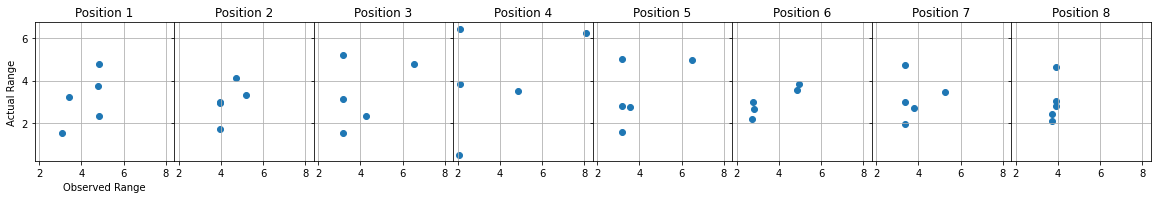

In [ ]:
f, axs = plt.subplots(1,8,sharex=True, sharey=True, figsize=(20,6))
for ax, mr, lr, i in zip(axs, mean_ranges, l_ranges, range(8)):
    ax.set_aspect('equal', 'box')
    ax.scatter(mr, lr)
    ax.grid()
    ax.set_title(f"Position {i+1}")

axs[0].set_xlabel("Observed Range")
axs[0].set_ylabel("Actual Range")
plt.subplots_adjust(wspace=0.0, hspace=0.0)

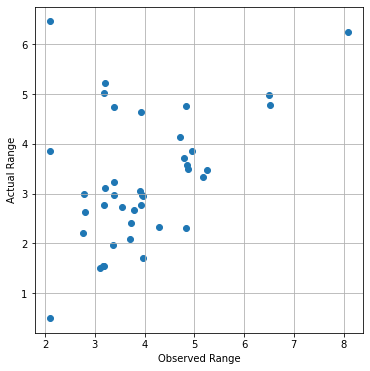

In [ ]:
f, ax = plt.subplots(1,1,sharex=True, sharey=True, figsize=(20,6))
ax.set_aspect('equal', 'box')
ax.scatter(mean_ranges, l_ranges)
ax.grid()

ax.set_xlabel("Observed Range")
ax.set_ylabel("Actual Range")
plt.subplots_adjust(wspace=0.0, hspace=0.0)

In [ ]:
from scipy.optimize import minimize

def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

l_h_locs = h_locs[:, :]
l_ranges = np.array((
    (1.51,3.23,4.77,3.72,2.30),
    (3.33,4.14,2.96,2.98,1.70),
    (4.79,5.22,1.54,3.12,2.33),
    (6.24,6.46,0.50,3.86,3.50),
    (4.99,5.02,1.55,2.78,2.73),
    (3.86,3.57,3.00,2.20,2.64),
    (2.97,1.96,4.74,2.68,3.48),
    (2.08,2.41,4.64,3.05,2.78)
)) * 1.3  + 0.5 

x0 = (l_h_locs[None, :, :] * 1.0 / l_ranges[:, :, None]).sum(axis=1) / (1.0 / l_ranges[:, :, None]).sum(axis=1)

locs = np.empty((l_ranges.shape[0], l_h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, l_ranges)):
    locs[i] = minimize(error, xx0, args=(l_h_locs[:, :], ran), method='Nelder-Mead').x
    print(xx0, ran, locs[i])


[ 4.1317119   1.82834398 -1.41172192] [2.463 4.699 6.701 5.336 3.49 ] [ 5.80558681  4.55274747 -2.43233896]
[ 3.32823299  1.69800172 -1.60071608] [4.829 5.882 4.348 4.374 2.71 ] [ 2.5065711   4.00389244 -4.00920448]
[ 2.68033777  1.57374927 -1.53193167] [6.727 7.286 2.502 4.556 3.529] [-0.39820889  3.04861197 -2.88847299]
[ 1.68105097  1.50056431 -1.33065301] [8.612 8.898 1.15  5.518 5.05 ] [-2.02564006  1.6404468  -0.94252341]
[ 2.68521716  1.4859252  -1.54352166] [6.987 7.026 2.515 4.114 4.049] [-0.48668587  1.79195852 -3.44222165]
[ 3.36307855  1.4074898  -1.64163953] [5.518 5.141 4.4   3.36  3.932] [ 2.61438374  1.57147659 -5.10377365]
[ 4.07220327  1.28727059 -1.57480347] [4.361 3.048 6.662 3.984 5.024] [ 5.27664591 -1.03358414  0.81997332]
[ 4.08567319  1.54859334 -1.49785566] [3.204 3.633 6.532 4.465 4.114] [ 6.1349172   2.75707751 -3.81181672]


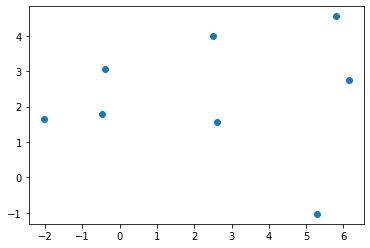

In [ ]:
plt.scatter(locs[:, 0], locs[:, 1])

# Check Pings Again

In [ ]:
run = runs[2]
pico_file = f"{root}/{run}/pico.npts"
t, y = load_pico_file(pico_file)

In [ ]:
# plt.plot(t,MA()(y[:, 0]))
# plt.plot(t,y[:, 1:])

In [ ]:
import matplotlib.pyplot as plt

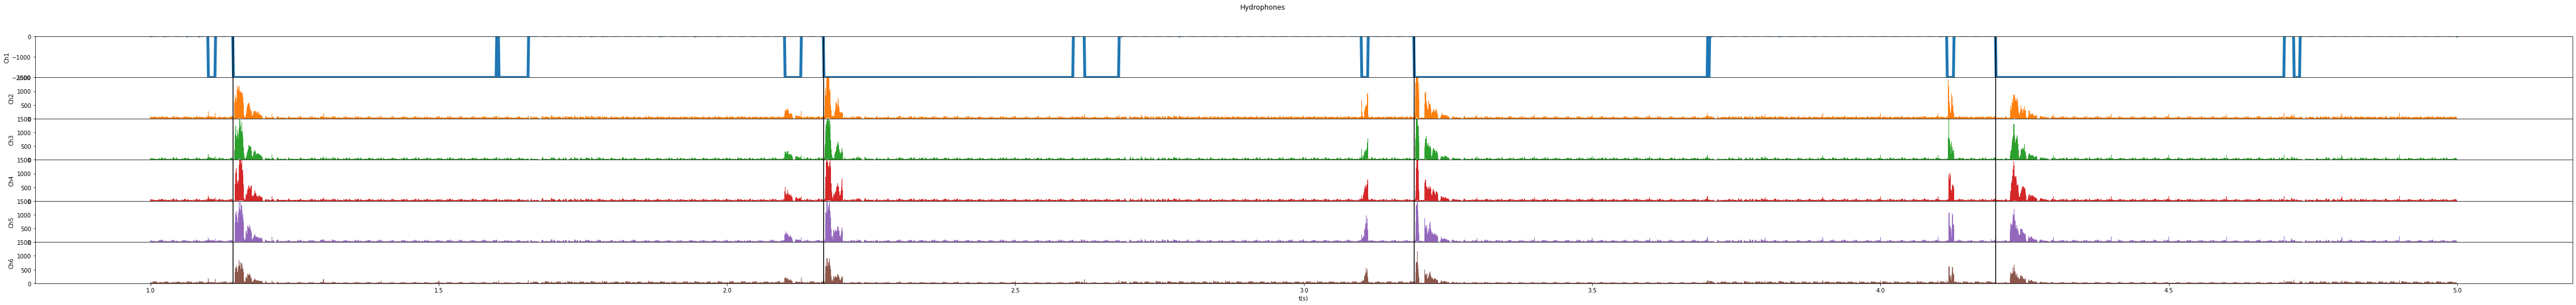

In [ ]:
f, axs = plt.subplots(y.shape[1], 1, figsize=(80,8), sharex='col')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Default 

# loc = slice(0, len(arr)//5)
loc = slice(int(1.0 * fs), int(5.0 * fs))
for (i, ax), row, color in zip(enumerate(axs), y.T, colors):
    if i != 0:
        ax.plot(t[loc], row[loc], label=f"Ch{i+1}", color=color, linewidth=0.5)
        ax.set_ylim(0,1500)
    else:
        ax.plot(t[loc], MA(apply_abs=False)(row[loc]), label=f"Ch{i+1}", color=color, linewidth=5)
        ax.set_ylim(-2000,0)

    ax.set_ylabel(f"Ch{i+1}")
    ax.set_xlim(*ax.get_xlim())


for ax in axs:
    for ts in get_ping_indices(y[:, 0]) * dt:
        ax.axvline(ts, color='black')

ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()

array([ 0.099999,  1.14333 ,  2.167326,  3.191322,  4.199999,  5.239315,
        6.263311,  7.287307,  8.299999,  9.335299, 10.359295, 11.383291,
       12.399999, 13.431283, 14.455279, 15.479275, 16.499999, 17.499999,
       18.551263, 19.575258, 20.599254, 21.599999, 22.647246, 23.671242,
       24.695238, 25.699999, 26.743229, 27.767225, 28.791221, 29.799999,
       30.839213, 31.863208, 32.887204, 33.899999, 34.935196, 35.959191,
       36.983187, 37.999999, 39.031178, 40.055174, 41.07917 , 42.099999,
       43.127161, 44.151156, 45.175152, 46.199148, 47.223144, 48.247139,
       49.271135, 50.29513 ])

In [ ]:
t0

# IMU



In [ ]:
fs = 50
dt = 1.0 / fs

In [ ]:
!ls 081221_final_fishhook_tests/**

081221_final_fishhook_tests/pretest_1:
imu.csv  pico.npts  times.log

081221_final_fishhook_tests/pretest_2:
imu.csv  pico.npts  times.log

081221_final_fishhook_tests/stationary_1:
pico.npts

081221_final_fishhook_tests/stationary_2:
pico.npts

081221_final_fishhook_tests/stationary_3:
pico.npts

081221_final_fishhook_tests/stationary_4:
pico.npts

081221_final_fishhook_tests/stationary_5:
pico.npts

081221_final_fishhook_tests/stationary_6:
pico.npts

081221_final_fishhook_tests/stationary_7:
pico.npts

081221_final_fishhook_tests/stationary_8:
pico.npts

081221_final_fishhook_tests/triangle_1:
imu.csv  pico.npts  times.log

081221_final_fishhook_tests/triangle_2:
imu.csv  pico.npts  times.log

081221_final_fishhook_tests/triangle_3:
imu.csv  pico.npts


In [ ]:
run_name = 'triangle_2'

In [ ]:
imu_orig = np.loadtxt(f'{root}/{run_name}/imu.csv', delimiter=',', skiprows=1)

In [ ]:
imu = imu_orig.copy()
imu[:, 0] -= imu_orig[0,0]
# imu[:, 4:6] -= imu[:int(fs * 2), 4:6].mean(axis=0)

In [ ]:
times = {}
for l in open(f'{root}/{run_name}/times.log', 'r'):
    vals = l[:-1].split(' ')[0:2]
    times[float(vals[0]) - imu_orig[0,0]] = vals[1]

In [ ]:
times

{}

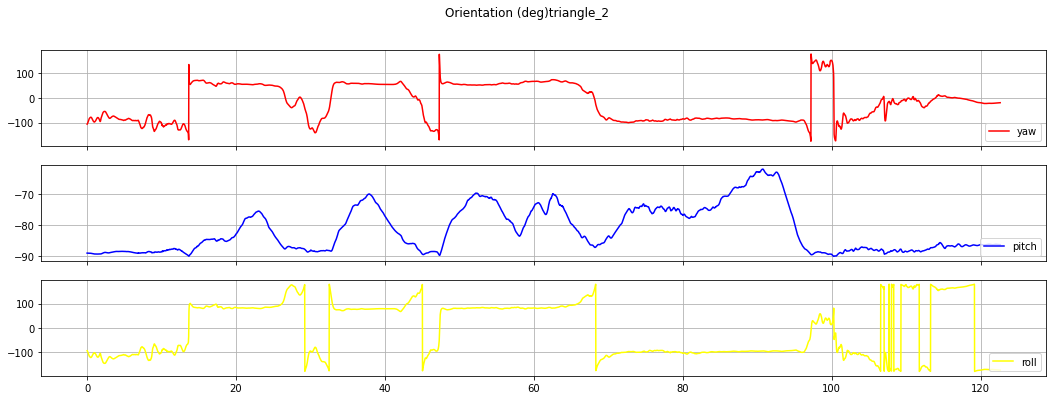

In [ ]:
fig, ax = plt.subplots(3, figsize=(18,6), sharex=True)

ax[0].plot(imu[:,0], imu[:,1], label='yaw', color='red')
ax[0].legend(loc='lower right')

ax[1].plot(imu[:,0], imu[:,2], color='blue', label='pitch')
ax[1].legend(loc='lower right')

ax[2].plot(imu[:,0], imu[:,3], color='yellow', label='roll')
for a in ax:
    for time, label in times.items():
        a.axvline(x=time, label=(label if label != '' else None))
ax[2].legend(loc='lower right')
for a in ax:
    a.grid()



fig.suptitle("Orientation (deg)" + run_name);

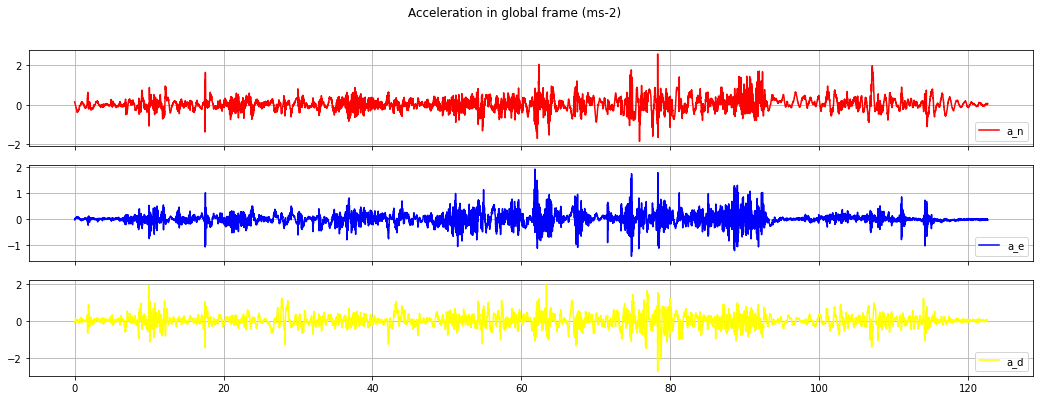

In [ ]:
fig, ax = plt.subplots(3, figsize=(18,6), sharex=True)

acc = imu[:, 4:7] #- imu[:, 4:7].mean(axis=0)

ax[0].plot(imu[:,0], acc[:,0], color='red', label='a_n')
ax[0].legend(loc='lower right')
ax[1].plot(imu[:,0], acc[:,1], color='blue', label='a_e')
ax[1].legend(loc='lower right')
ax[2].plot(imu[:,0], acc[:,2], color='yellow', label='a_d')
for a in ax:
    for time, label in times.items():
        a.axvline(x=time, label=(label if label != '' else None))
ax[2].legend(loc='lower right')
for a in ax:
    a.grid()

fig.suptitle("Acceleration in global frame (ms-2)");

In [ ]:
zero_state = imu[slice(0, int(fs * 5)), 2:4].mean(axis=0)
imu_dev = imu[:, 2:4] - zero_state
# imu_dev = MA(fs=50, dt=0.4)(imu_dev)
imu_dev = np.rad2deg(np.unwrap(np.deg2rad(imu_dev), axis=0))
imu_dev = np.abs(imu_dev / 180)
in_motion = np.linalg.norm(imu_dev, axis=1) > 0.25
in_motion = imu_dev[:, 0] > 0.025

Text(0, 0.5, 'Deviation (rad / pi)')

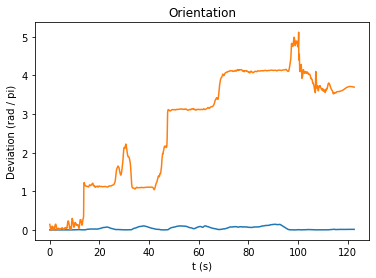

In [ ]:
plt.plot(imu[:, 0], imu_dev)
plt.title('Orientation')
plt.xlabel('t (s)')
plt.ylabel('Deviation (rad / pi)')

Text(0.5, 0, 't (s)')

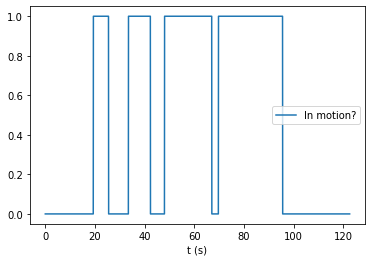

In [ ]:
plt.plot(imu[:, 0], in_motion, label="In motion?")
plt.legend()
for time, label in times.items():
    plt.axvline(x=time, color='red')#, label=(label if label != '' else None))
plt.xlabel('t (s)')


In [ ]:
all_indices = np.where(np.diff(in_motion))[0]
all_indices = all_indices[:len(all_indices) - (len(all_indices)%2)]
all_indices = np.insert(all_indices, 0, 0)
all_indices = np.insert(all_indices, all_indices.shape[0], in_motion.shape[0])

In [ ]:
zero_state = imu[slice(0, int(fs * 5)), 4:7].mean(axis=0)
acc_dev = imu[:, 4:7] - zero_state

In [ ]:
vel = np.cumsum(acc_dev[:, :], axis=0) * dt
vel_cor = vel.copy()
indices = all_indices

zero_state = True
zero_vel = vel_cor[indices[0]:indices[1]].mean(axis=0)
for i in range(len(indices) - 1):
    if zero_state:
        # vel_cor[indices[i]:indices[i+1]] -= zero_vel
        vel_cor[indices[i]:indices[i+1]] = 0
        vel_cor[indices[i+1]:] -= zero_vel
    else:
        zero_vel = vel_cor[indices[i+1]:indices[i+2]].mean(axis=0)
        vel_cor[indices[i]:indices[i+1], ...] -= vel_cor[indices[i]+1]
        vel_cor[indices[i]:indices[i+1], ...] -= (vel_cor[indices[i+1]-1] * np.linspace(0, 1, indices[i+1] - indices[i])[:, None])
    zero_state = not zero_state

Text(0, 0.5, 'Vel (ms-1)')

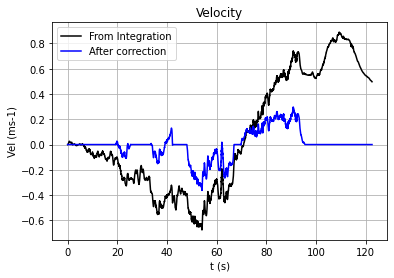

In [ ]:
plt.plot(imu[:, 0], vel[:, 1], color='black', label='From Integration')
plt.plot(imu[:, 0], vel_cor[:, 1], color='blue', label='After correction')
plt.grid()
plt.legend()
for time, label in times.items():
    plt.axvline(x=time, color='red', alpha=0.4)#, label=(label if label != '' else None))
plt.title('Velocity')
plt.xlabel('t (s)')
plt.ylabel('Vel (ms-1)')

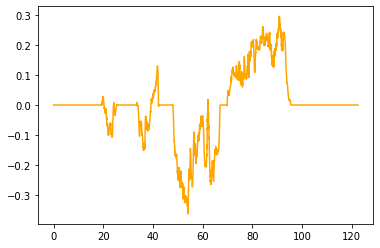

In [ ]:
plt.plot(imu[:, 0], vel_cor[:, 1], color='orange')

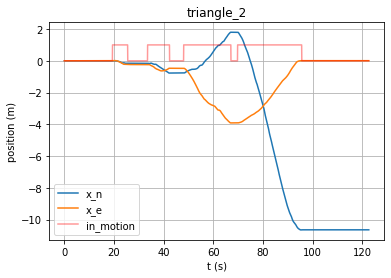

In [ ]:
# plt.figure(figsize=(20,6))
plt.title(run_name)

for v, label in zip(vel_cor.T[:2], ('x_n', 'x_e', 'x_d')):
    plt.plot(imu[:, 0], np.cumsum(v, axis=0) * dt, label=label)

plt.plot(imu[:, 0], in_motion, color='red', label='in_motion', alpha=0.4)

for time, label in times.items():
    plt.axvline(x=time, color='black', alpha=0.4)#, label=(label if label != '' else None))

plt.legend()
plt.grid()
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.show()


Text(0.5, 1.0, 'triangle_2')

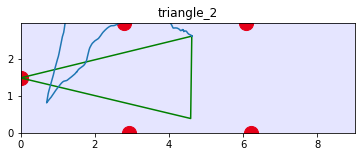

In [ ]:
draw_pool(plt.gca())
plt.plot(ground_truth[0][0] +  np.cumsum(vel_cor[:, 1], axis=0) * dt, ground_truth[0][1] - np.cumsum(vel_cor[:, 0], axis=0) * dt)
plt.title(run_name)

Text(0.5, 1.0, 'triangle_2')

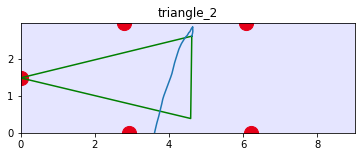

In [ ]:
draw_pool(plt.gca())
plt.plot(ground_truth[0][0] +  np.cumsum(vel[:, 1], axis=0) * dt, ground_truth[0][1] - np.cumsum(vel[:, 0], axis=0) * dt)
plt.title(run_name)